In [1]:
import sys
sys.path.append('../scripts/')
from robot import * 
from scipy.stats import multivariate_normal
import random
import copy

In [2]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight  = weight
        
    def motion_update(self,nu,omega,time,noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        # 式(5.12)処理
        noised_nu = nu + ns[0] * math.sqrt(abs(nu) / time) + ns[1] * math.sqrt(abs(omega) / time)
        noised_omega = omega + ns[2] * math.sqrt(abs(nu) / time) + ns[3] * math.sqrt(abs(omega) / time)
        self.pose = IdealRobot.state_transition(noised_nu,noised_omega,time,self.pose) # 粒子の移動
        
    def observation_update(self,observation,envmap,distance_dev_rate,direction_dev):
        #print(observation)
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            # 粒子の位置と地図からランドマークの距離と方角を算出
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.observation_function(self.pose, pos_on_map)
            
            # 尤度計算
            distance_dev = distance_dev_rate * particle_suggest_pos[0] # 距離に比例
            cov = np.diag(np.array([distance_dev**2 ,direction_dev**2])) # 分散
            self.weight *= multivariate_normal(mean = particle_suggest_pos, cov = cov).pdf(obs_pos) # 共分散行列
 

In [7]:
# 現在地と粒子の数

class Mcl:
    # motion_nosise_stds:標準偏差σ_ab
    def __init__(self,envmap,init_pose,num,motion_noise_stds = {"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},\
                distance_dev_rate = 0.14,direction_dev = 0.05):
        # distance_dev_rate: ,direction_dev_rate: 
        
        self.particles = [Particle(init_pose, 1.0 / num) for i in range(num)]
        
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2,v["no"]**2,v["on"]**2,v["oo"]**2 ]) # 与えられた要素を二乗して対角行列へ返す
        self.motion_noise_rate_pdf = multivariate_normal(cov = c)
        
    def motion_update(self,nu,omega,time):
        #print(self.motion_noise_rate_pdf.cov)
        # class Particl のmotion_updateを全粒子に行う
        for p in self.particles: p.motion_update(nu,omega,time,self.motion_noise_rate_pdf)
   
    def observation_update(self,observation):
        for  p in self.particles: p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
        self.resampling()
        
    # 系統リサンプリング
    def resampling(self):
        ws = np.cumsum([e.weight for e in self.particles]) # 最後の要素が重みの合計 足し合わせていく
        if ws[-1] < 1e-100: ws = [e + 1e-100 for e in ws] # 重みの合計が0にならないように
        
        step = ws[-1] / len(self.particles)
        r = np.random.uniform(0.0,step)
        cur_pos = 0
        ps = []
        
        while(len(ps) < len(self.particles)):
            if r < ws[cur_pos]:
                ps.append(self.particles[cur_pos])
                r += step
            else:
                cur_pos += 1
        
        self.particles = [copy.deepcopy(e) for e in ps] # リサンプリングで選ばれた粒子の保存
        for p in self.particles: p.weight = 1.0 / len(self.particles) # 正規化
        
    # 粒子を描画する(位置、姿勢)
    def draw(self,ax,elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        # 重みに比例してベクトルを長くする
        vxs = [math.cos(p.pose[2]) * p.weight * len(self.particles) for p in self.particles] # ベクトルのx成分
        vys = [math.sin(p.pose[2]) * p.weight * len(self.particles) for p in self.particles]
        elems.append(ax.quiver(xs, ys, vxs, vys, \
                    angles = 'xy', scale_units = 'xy', scale = 1.5, color = "blue" , alpha = 0.5)) # 粒子の位置と姿勢を登録
        
   

In [8]:
class EstimationAgent(Agent):
    def __init__(self,time_interval,nu,omega,estimator):
        super().__init__(nu,omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self,observation = None):
        self.estimator.motion_update(self.prev_nu,self.prev_omega,self.time_interval)# class Mclのmotion_update
        self.prev_nu,self.prev_omega = self.nu,self.omega
        self.estimator.observation_update(observation)
        return self.nu,self.omega

    def draw(self,ax,elems):
        self.estimator.draw(ax,elems)
        #elems.append(ax.text(0,0,"hoge",fontsize = 10))

<IPython.core.display.Javascript object>


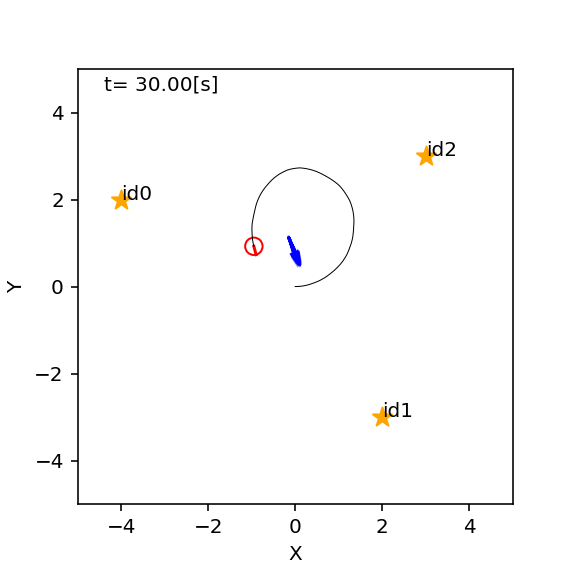

In [10]:
def trial():
    time_interval = 0.1
    world = World(30,time_interval,debug = False)
    
    m = Map()
    for ln in [(-4,2),(2,-3),(3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)
    
    initial_pose = np.array([0,0,0]).T
    estimator = Mcl(m,initial_pose,100) # 地図を
    a = EstimationAgent(time_interval,0.2,10.0 / 180 * math.pi,estimator)
    r = Robot(initial_pose,sensor = Camera(m),agent = a,color = "red") # このカメラ、ファントム、オクルージョン...全部込み込み
    world.append(r)
    
    world.draw()
    
trial()
# リサンプリングで粒子を頑張らせた